# ARIMA / GARCH Based Recovery Recommendations
___

### TOC

- [Intro](#hrv)
    - [HRV](#hrv)
    - [ARIMA and GARCH](#arima-garch)
    - [Possible Applications](#examples)
- [Methodology](#methodology)
- [ARIMA](#arima)
    
    
### Intro – HRV<a id="hrv">
[Heart Rate Variability](https://en.wikipedia.org/wiki/Heart_rate_variability) is the primary meaure of preparedness for stress which My Oura ring uses to advise me on how much exercise would be ideal for me for that day. It lines up quite well with my subjective feeling, but an intra-day comparison shows that there's zero correlation. Of course, I really ought to consider the few days of data before. I'll get around to that.

### ARIMA and GARCH <a id="arima-garch">
In any case, I thought i'd try throwing [ARIMA](https://python-bloggers.com/2021/04/arima-model-in-python/) and GARCH at my own health data and seeing what would come of it. Both models should be useable as a kind of daily (or higher res, maybe weekly) prediction thingy. The question on my mind which I think I'd like to gesticulate a little on here is what these predictions would be valuable for. Of course, the practice of it and the pleasure of building it are both individually sufficient, but to grant myself one more indulgence, I want to give the project a life of it's own. To me, this means purpose. What can this model provide that I don't already have?
    
Primarily, a forecast. The oura app does do a kind of forecasting in the sense that it makes vauge suggestions regarding how much stress I might be able to tolerate. I want predictions with regards to how much deep sleep I can expect, or the HRV score I can expect tomorrow. I do have thoughts on what those scores might be before I engage in some activity the day before. If I have a guide as to how I might do tomorrow, maybe I can make better choices today.

Originally, I believe the ARCH/GARCH models emerged for making econometric and stock market predictions by taking into consideration autocorrelative implications for hetroskedasticity - in english, (G)ARCH is a prediction model that is backwards-looking (in time, when applied to timeseries) and takes into consideration the volatility of previous data. Naturally, I'm goign to throw this model at econometric things. See what comes of it. Maybe I can try doing some kind of analysis of TA patterns - they have a self fulfilling element to them. Maybe that is simply an expression of autocorrelation.

### Examples <a id="examples">

Application wise, there's a few immediate ideas that come to mind for an integrated sytem:

Example 1
> Simple trend analysis - A prediction is informative. Having access to information about the future is inherently (as far as I care to justify) valubale

Exmaple 2
> Moment adjustments - I'm out past the time i'll usually go to sleep, probably drinking. The application automatically guesses how much sleep I need and based on that expectation, adjusts my Hue light auto-on feature and my alarm to match it appropriately. Of course, I can modify and sign off on the suggestion before the updates are made.

### Methodology <a id="methodology">

1. ARIMA on HRV
    
    
2. GARCH deep sleep


    
### biblio

- [How to ARIMA](https://python-bloggers.com/2021/04/arima-model-in-python/)
- [12 rules for arima](https://people.duke.edu/~rnau/arimrule.htm)
- [ARIMA forecasting covid 19 cases](https://www.medrxiv.org/content/10.1101/2020.05.16.20103895v1.full.pdf)
- 

In [30]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

variables_of_interest = [
    "deep_sleep_time",
    "light_sleep_time",
    "average_hrv",
    "lowest_resting_heart_rate",
]

In [5]:
# --- Get Oura Data

df = pd.read_csv("data/oura_clean.csv")
df.drop("Unnamed: 0", axis=1, inplace=True)
df.set_index('date', inplace=True)
df = df[variables_of_interest]
display(df.head())

,deep_sleep_time,light_sleep_time,average_hrv,lowest_resting_heart_rate
date,,,,
2020-01-01,6150.0,14760.0,112.0,45.0
2020-01-02,6030.0,15270.0,97.0,47.0
2020-01-03,5790.0,16500.0,129.0,44.0
2020-01-04,4200.0,14460.0,103.0,47.0
2020-01-05,8190.0,13170.0,101.0,48.0


### ARIMA <a id="arima">

To build the appropriate ARIMA model, 7 parameters need to be discerned:
1. p - observational lag value
2. d - differencing required to observational stationarity
3. q - size of observational moving average window
4. P - seasonal lag value
5. D - differencing required seasonal stationarity
6. Q - size of seasonal moving average window
7. m - n.observations for the first season

There are some values which are pretty easy to fill in immediately.
- m = 7 makes sense since primary cycle was weekly and observations are daily

#### Steps to be taken

1. Find d and D by checking for stationarity at the observational and seasonal resolution
2. Find p, P, q and Q by checking ACF and PACF at the observational and seasonal resolution
3. Generate statsmodel ARIMA using the discerned values in the previous steps
4. Plot a forecast to sniff test

In [34]:
m = 7

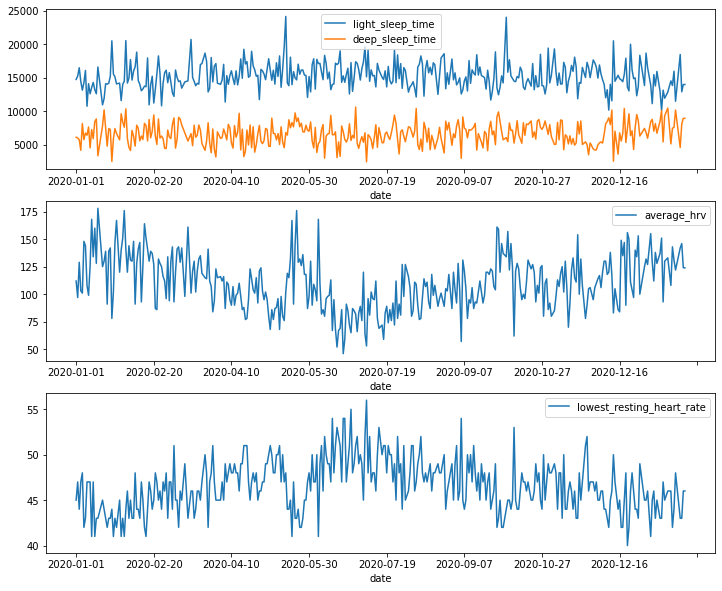

In [23]:
# --- 1. Find d and D by checking for stationarity

    # - 1.1 Eyeball Test
    # - 1.2 Observations - Augmented Dicky Fuller Testing
    # - 1.3 Seasonal - Augmented Dicky Fuller Testing

# --- 1.1 Eyeball Test

_, ax = plt.subplots(3, 1, figsize=(12, 10))
df.plot(y=['light_sleep_time', 'deep_sleep_time'], ax=ax[0]);
df.plot(y="average_hrv", ax=ax[1]);
df.plot(y="lowest_resting_heart_rate", ax=ax[2]);

They all certainly look stationary. I would expect all of them to crush the H_0, but the sleep times to get extra tiny p values.

I don't think I see any (weekly) seasonality, but that might be a resolution thing.

In [35]:
# --- 1.2 Observations - Augmented Dicky Fuller Testing

# for each timeseries:
    # Null Hypothesis: The timeseries has a unit root
    # Test H_0
    # Rejection of the null hypothesis (pvalue < 0.005) --> The timeseries has no unit root

from statsmodels.tsa.stattools import adfuller

results = {}
for col in df.columns:
    result = adfuller(df[col])
    results[col] = dict(zip(['adf', 'pvalue', 'usedlag', 'nobs',
                             'critical' 'values', 'icbest'],result)
                       )
print(json.dumps(results, sort_keys=True, indent=4))

{
    "average_hrv": {
        "adf": -3.860719113148694,
        "criticalvalues": {
            "1%": -3.4473167281607155,
            "10%": -2.5707536074503134,
            "5%": -2.869018036958473
        },
        "icbest": 3281.830194262184,
        "nobs": 388,
        "pvalue": 0.002343723844541309,
        "usedlag": 4
    },
    "deep_sleep_time": {
        "adf": -6.717358160036419,
        "criticalvalues": {
            "1%": -3.4473167281607155,
            "10%": -2.5707536074503134,
            "5%": -2.869018036958473
        },
        "icbest": 6595.4462481317,
        "nobs": 388,
        "pvalue": 3.5540952253328055e-09,
        "usedlag": 4
    },
    "light_sleep_time": {
        "adf": -16.38292752415294,
        "criticalvalues": {
            "1%": -3.44714244478345,
            "10%": -2.5707127699396084,
            "5%": -2.8689414326247995
        },
        "icbest": 6761.279116220355,
        "nobs": 392,
        "pvalue": 2.740416783622128e-29,
      

For all timeseries, $p < 0.05$. we can reject the null hypothesis for all timeseries with $d = 0$.

All of the timeseries are stationary when viewed from the obsevational resolution

In [48]:
# --- 1.3 Seasonal - Augmented Dicky Fuller Testing

# In this case, I don't expect the seasonal stationarity tests 
# to yield roots so i'm just going to implement a simple loop

for col in df.columns:
    df["s_{}".format(col)] = df[col] - df[col].shift(m)
    pval = adfuller(df["s_{}".format(col)].dropna())[1]
    if p_val < 0.05:
        print("{c} passes with pval {p}".format(c=col, p=pval))

deep_sleep_time passes with pval 1.480233405667031e-14
light_sleep_time passes with pval 9.352535154498334e-13
average_hrv passes with pval 1.283494707467697e-05
lowest_resting_heart_rate passes with pval 6.6796880311287135e-06


Thus $D = 0$ since no differencing at the seasonal resolution is required

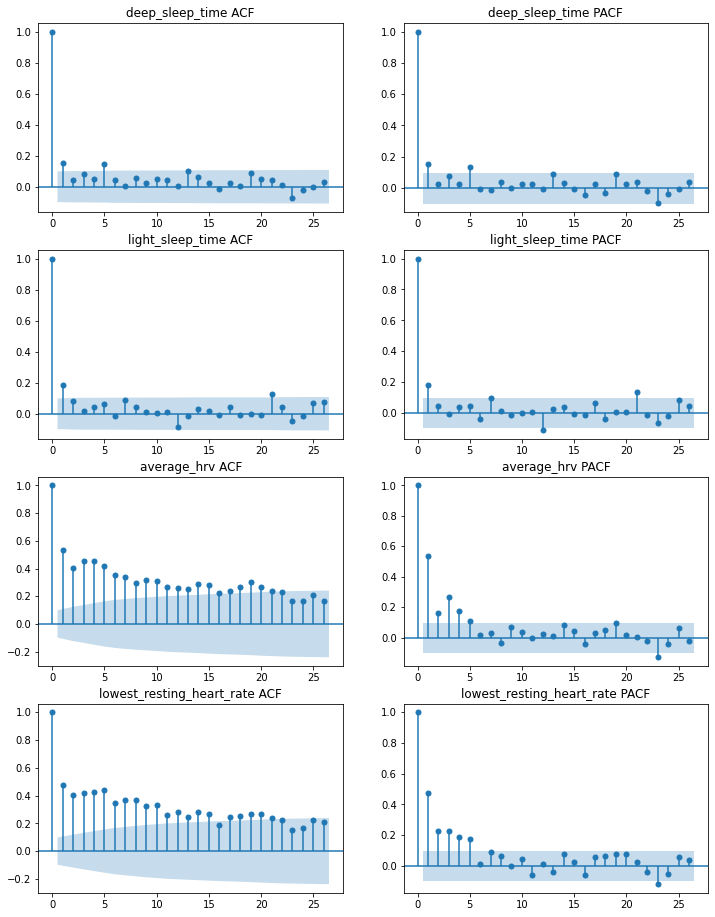

In [75]:
# --- 2. Find p, P, q and Q to check for ACF and PACF
    
    # 2.1 ACF, PACF via the Eyeballs
    # 2.2 ?

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# --- 2.1 Via the Eyeballs

rows = len(variables_of_interest)
_, ax = plt.subplots(rows, 2, figsize=(12, 4 * rows))
ax = ax.flatten()

for i, col in enumerate(variables_of_interest):
    i = i+1 # pesky zero
    plot_acf(df[col], ax=ax[i * 2 - 2]);
    plot_pacf(df[col], ax=ax[i * 2 - 1]);
    ax[i * 2 - 2].set_title("{c} ACF".format(c=col))
    ax[i * 2 - 1].set_title("{c} PACF".format(c=col))

#### 1. Deep Sleep
ACF falls dramatically at 1, as does PACF. 

Take $p=q=1$

#### 2. Light Sleep
Same as deep sleep

#### HRV
ACF falls more or less gradually and PACF drops only at 2.

This suggests we should start with a $p = 1$, 

#### Lowest resting heart rate
